We're going to try to build the strength of schedule metric for NCAA football and use it to estimate which team is "objectively the best" for a given year.

In [1]:
import pandas as pd

DATA = '/kaggle/input/college-football-team-stats-2002-to-january-2024/cfb_box-scores_2002-2023.csv'
df = pd.read_csv(filepath_or_buffer=DATA)
df.head()

,season,week,date,time_et,game_type,away,home,rank_away,rank_home,conf_away,...,int_away,int_home,pen_num_away,pen_yards_away,pen_num_home,pen_yards_home,possession_away,possession_home,attendance,tv
0,2002,1.0,2002-08-22,7:30 PM,regular,Colorado State,Virginia,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57120.0,NaN
1,2002,1.0,2002-08-23,8:00 PM,regular,Fresno State,Wisconsin,NaN,25.0,wac,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75136.0,NaN
2,2002,1.0,2002-08-24,2:30 PM,regular,Texas Tech,Ohio State,NaN,13.0,big12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100037.0,NaN
3,2002,1.0,2002-08-24,4:30 PM,regular,New Mexico,NC State,NaN,NaN,mwc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47018.0,NaN
4,2002,1.0,2002-08-24,7:45 PM,regular,Arizona State,Nebraska,NaN,10.0,pac12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77779.0,NaN


How big is our dataset?

<Axes: xlabel='season'>

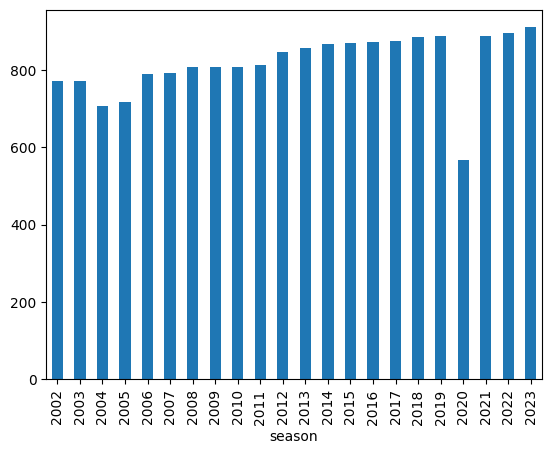

In [2]:
df['season'].value_counts().sort_index().plot(kind='bar')

We have roughly 800 games a year for 21 years; that's a lot of games.

Let's get just the win/loss figures first, and put them in a separate DataFrame.

In [3]:
win_loss_df = df[['season', 'home', 'away', 'score_away', 'score_home']].copy()
win_loss_df['winner'] = win_loss_df.apply(axis='columns', func=lambda x: 'home' if x['score_home'] > x['score_away'] else 'away')
win_loss_df['W'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] > x['score_away'] else x['away'])
win_loss_df['L'] = win_loss_df.apply(axis='columns', func=lambda x: x['home'] if x['score_home'] < x['score_away'] else x['away'])

Which teams have the most losses over the period of interest?

In [4]:
win_loss_df['L'].value_counts().head(n=10).to_frame().T

L,UNLV,New Mexico State,Kansas,Akron,Eastern Michigan,UTEP,Vanderbilt,UL-Monroe,New Mexico,Illinois
count,182,182,177,176,176,174,174,170,170,168


Which teams have the most wins over the period of interest?

In [5]:
win_loss_df['W'].value_counts().head(n=10).to_frame().T

W,Ohio State,Alabama,Georgia,Oklahoma,Boise State,Clemson,LSU,USC,Oregon,Wisconsin
count,244,243,232,231,231,220,216,205,203,202


The problem we're trying to solve here goes like this:
* There are more than 130 FBS teams and only ten weeks, so it is impossible to have every pair of teams play a game
* This means that in a given season there may be multiple undefeated teams
* And of course there may be one-loss or two-loss teams that are probably better than one or more of the undefeated teams
Strength of schedule is one metric that attempts to weight the fact that some teams play a schedule of better teams than others.

In this workbook we are going to look at two metrics described here: https://en.wikipedia.org/wiki/Strength_of_schedule


In [6]:
win_loss_df.head(n=5)

,season,home,away,score_away,score_home,winner,W,L
0,2002,Virginia,Colorado State,35,29,away,Colorado State,Virginia
1,2002,Wisconsin,Fresno State,21,23,home,Wisconsin,Fresno State
2,2002,Ohio State,Texas Tech,21,45,home,Ohio State,Texas Tech
3,2002,NC State,New Mexico,14,34,home,NC State,New Mexico
4,2002,Nebraska,Arizona State,10,48,home,Nebraska,Arizona State


Let's collect each year into its own DataFrame. This will make it easier to calculate each team's results for each season below.

In [7]:
wl = {season: win_loss_df[win_loss_df['season'] == season] for season in win_loss_df['season'].unique().tolist()}

How many distinct home teams do we have?

In [8]:
df['home'].nunique()

139

One of the difficulties with this dataset is that it includes games where an FBS team schedules an FCS team for an early-season win, and probably other complicated situations. We have rather more away teams than home teams, and we have home teams that appear a suspiciously small number of times. 

Let's build the dataset we really want: for each season and team, let's find the games, wins, and losses.

In [9]:
records = []
teams = df['home'].unique().tolist()
for team in teams:
    for season in range(2002, 2023):
        wins = 0
        games = 0
        home_df = wl[season][wl[season]['home'] == team]
        wins += len(home_df[home_df['winner'] == 'home'])
        games += len(home_df)
        away_df = wl[season][wl[season]['away'] == team]
        wins += len(away_df[away_df['winner'] == 'away'])
        games += len(away_df)
        losses = games - wins
        records.append(pd.Series(data={'season': season, 'team': team, 'games': games, 'wins': wins, 'losses': losses, } ))
records_df = pd.DataFrame(data=records)
records_df.head()

,season,team,games,wins,losses
0,2002,Virginia,14,9,5
1,2003,Virginia,13,8,5
2,2004,Virginia,12,8,4
3,2005,Virginia,12,7,5
4,2006,Virginia,12,5,7


Now we're ready to calculate opponents records using this DataFrame.

In [10]:
result = []
for team in teams:
    for season in range(2002, 2023):
        home_df = wl[season][wl[season]['home'] == team]
        away_df = wl[season][wl[season]['away'] == team]
        opponents = home_df['away'].tolist() + away_df['home'].tolist()
        opponents_df = records_df[(records_df['team'].isin(opponents)) & (records_df['season'] == season)]
        result.append(pd.Series(
            data={'team': team, 'season': season, 'opponent games': opponents_df['games'].sum(), 'opponent wins': opponents_df['wins'].sum(),
                 'opponent losses': opponents_df['losses'].sum()}
        ))        
result_df = pd.DataFrame(data=result)
result_df['SOS'] = result_df['opponent wins'] / result_df['opponent games']
result_df.head()


,team,season,opponent games,opponent wins,opponent losses,SOS
0,Virginia,2002,183,104,79,0.568306
1,Virginia,2003,163,87,76,0.533742
2,Virginia,2004,140,77,63,0.550000
3,Virginia,2005,140,70,70,0.500000
4,Virginia,2006,152,75,77,0.493421


First let's take a look at the distribution of SOS. We expect it to have a mean of 0.5, but how much variance do we expect?

<Axes: xlabel='SOS', ylabel='Count'>

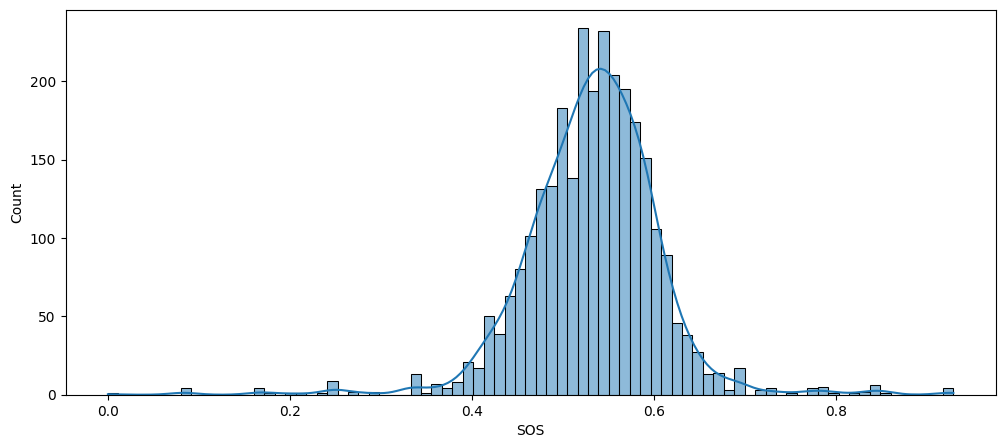

In [11]:
import matplotlib.pyplot as plt
from seaborn import histplot
from warnings import filterwarnings

filterwarnings(action='ignore', category=FutureWarning)

FIGSIZE = (12, 5)
plt.figure(figsize=FIGSIZE)
histplot(data=result_df, x='SOS', kde=True)

In [12]:
result_df['SOS'].mean(), result_df['SOS'].std()

(0.5322307967644311, 0.07408306146505)

Our mean SOS is higher than 0.5. Why would that be? It's hard to say. We have nearly 3000 instances, so we would expect our distribution to be smoother than it is. Maybe we should see if we have some teams that only appear a few times and introduce some skew because their schedules include so few games.